In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sklearn as sk
import scipy

In [3]:
data = pd.read_csv(r"Results.csv")

In [4]:
data.head()

,username,method,n_per_date,similarity,embedding_metric,num_previous_posts,num_timeframe_posts,num_articles,start,end,vectorization_time,embed_articles_time,embed_captions_time,jaccard,DateDiff,DateDiff Modified,Categorisation
0,forbes,roberta,1,cosine,weighted,16173,66,52,2023-09-01,2023-09-08,0.0,9.173465,1281.690992,0.175654,7,7,Weekly
1,forbes,roberta,5,cosine,weighted,16173,66,52,2023-09-01,2023-09-08,0.0,9.173465,1281.690992,0.145056,7,7,Weekly
2,forbes,roberta,1,manhattan,weighted,16173,66,52,2023-09-01,2023-09-08,0.0,9.173465,1281.690992,0.165708,7,7,Weekly
3,forbes,roberta,5,manhattan,weighted,16173,66,52,2023-09-01,2023-09-08,0.0,9.173465,1281.690992,0.149517,7,7,Weekly
4,forbes,roberta,1,euclidean,weighted,16173,66,52,2023-09-01,2023-09-08,0.0,9.173465,1281.690992,0.173415,7,7,Weekly


First we want to choose a similarity metric

In [5]:
data.groupby(['similarity'])['jaccard'].mean()

similarity
cosine       0.108419
euclidean    0.102913
manhattan    0.104285
Name: jaccard, dtype: float64

In [6]:
def assign_category(username):
    if username in ['forbes', 'bloomberg']:
        return 'Business'
    elif username in ['espn', 'pubitysport']:
        return 'Sports'
    else:
        return 'Entertainment'
    
data['category'] = np.vectorize(assign_category)(data['username'])

Similarity metric chosen: <b>cosine</b>

We also choose the weighting metric as <b>weighted</b> as that make more intuiutive sense and is also more informative when considering over a longer period.

In [7]:
data_updated = data[(data['similarity']=='cosine') & (data['embedding_metric']=='weighted')]

In [8]:
data_updated.groupby(['method'])['jaccard'].mean()

method
bow        0.106224
roberta    0.111472
tfidf      0.107309
Name: jaccard, dtype: float64

c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

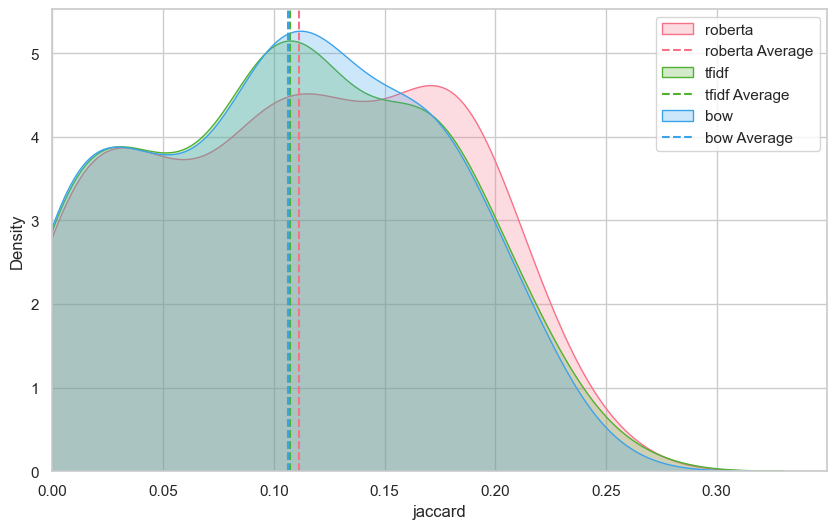

In [9]:
sns.set(style="whitegrid")

# Create a kernel density plot for each method on the same graph
plt.figure(figsize=(10, 6))
colors = sns.color_palette("husl", len(data_updated['method'].unique()))  # Use a color palette for different colors

for i, method in enumerate(data_updated['method'].unique()):
    sns.kdeplot(data_updated[data_updated['method'] == method]['jaccard'], label=method, fill=True, color=colors[i])
    avg_value = data_updated[data_updated['method'] == method]['jaccard'].mean()
    plt.axvline(x=avg_value, linestyle='--', color=colors[i], label=f'{method} Average')

# Set x-axis to start from 0
plt.xlim(0, None)
plt.legend()

We use the Kruskal-Wallis test to check for significance before making any conclusions. This is because we don't want to make any assumptions about the data distribution. Although it does look like they have similar variance from the graph above (implying we can use ANOVA), we find it better to use a less powerful data incase our ANOVA assumptions are voilated.

In [10]:
bow_data = data_updated[data_updated['method'] == 'bow']['jaccard']
roberta_data = data_updated[data_updated['method'] == 'roberta']['jaccard']
tfidf_data = data_updated[data_updated['method'] == 'tfidf']['jaccard']

# Perform Kruskal-Wallis test
h_statistic, p_value = scipy.stats.kruskal(bow_data, roberta_data, tfidf_data)

# Display the results
print(f'Kruskal-Wallis H-statistic: {h_statistic:.4f}')
print(f'Kruskal-Wallis p-value: {p_value:.4f}')

Kruskal-Wallis H-statistic: 0.8900
Kruskal-Wallis p-value: 0.6408


We find that the result is not statitically significant at this time. This indicates that the choice of model would require more domain based research to have an exact answer. The result of roberta being better could be down to the type of data fed within the dataset.

However from our research we find (Add why roberta might be better) so we choose to go ahead with roberta for our results.

In [11]:
data_updated.groupby(['n_per_date'])['jaccard'].mean()

n_per_date
1    0.115143
5    0.101527
Name: jaccard, dtype: float64

In [12]:
n_1_data = data_updated[data_updated['n_per_date'] == 1]['jaccard']
n_5_data = data_updated[data_updated['n_per_date'] == 5]['jaccard']

# Perform Kruskal-Wallis test
t_stat, p_value = scipy.stats.ttest_rel(n_1_data, n_5_data, alternative='greater')

# Display the results
print(f'T-Test statistic: {t_stat:.4f}')
print(f'T-Test p-value: {p_value:.4f}')

T-Test statistic: 11.9614
T-Test p-value: 0.0000


This makes sense as when we do 5 recommendations our metric calculates accuracy with everyone when compared to one. 

In [13]:
data_updated_2 = data_updated[(data_updated['n_per_date']==1) & (data_updated['method']=='roberta')]

In [14]:
data_updated_2.head()

,username,method,n_per_date,similarity,embedding_metric,num_previous_posts,num_timeframe_posts,num_articles,start,end,vectorization_time,embed_articles_time,embed_captions_time,jaccard,DateDiff,DateDiff Modified,Categorisation,category
0,forbes,roberta,1,cosine,weighted,16173,66,52,2023-09-01,2023-09-08,0.0,9.173465,1281.690992,0.175654,7,7,Weekly,Business
36,forbes,roberta,1,cosine,weighted,16252,99,41,2023-09-09,2023-09-16,0.0,6.428625,1099.340666,0.190596,7,7,Weekly,Business
72,forbes,roberta,1,cosine,weighted,16359,137,50,2023-09-17,2023-09-24,0.0,9.012769,1102.507976,0.151990,7,7,Weekly,Business
108,forbes,roberta,1,cosine,weighted,16504,112,29,2023-09-25,2023-09-30,0.0,4.817560,1092.941832,0.182055,5,7,Weekly,Business
144,forbes,roberta,1,cosine,weighted,16631,147,37,2023-10-01,2023-10-08,0.0,5.584200,1152.036287,0.169303,7,7,Weekly,Business


In [15]:
data_nov = data_updated_2[(data_updated_2['start']>='2023-11-01')]
data_pre_nov = data_updated_2[~(data_updated_2['start']>='2023-11-01')]

In [16]:
def remove_outliers(df, column):
    # Calculate the IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_filtered

# Apply outlier removal to 'data_nov'
data_nov_cleaned = remove_outliers(data_nov, 'num_articles')

# Apply outlier removal to 'data_pre_nov'
data_pre_nov_cleaned = remove_outliers(data_pre_nov, 'num_articles')

c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


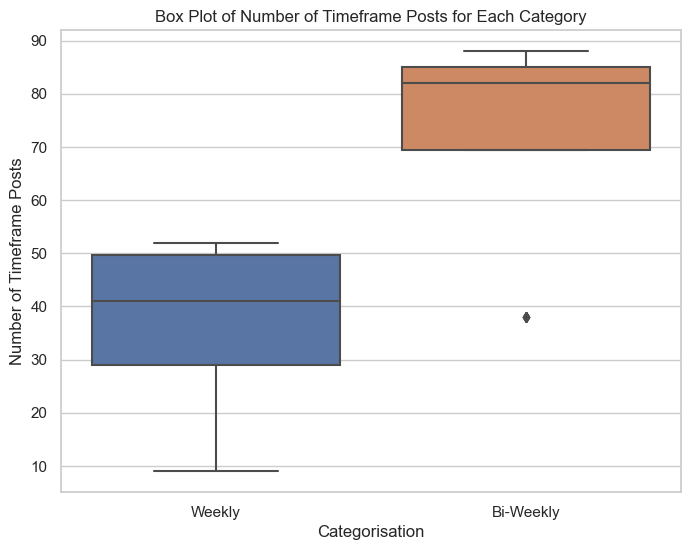

In [17]:
sns.set(style="whitegrid")

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Categorisation', y='num_articles', data=data_pre_nov)

# Add labels and title
plt.xlabel('Categorisation')
plt.ylabel('Number of Timeframe Posts')
plt.title('Box Plot of Number of Timeframe Posts for Each Category')

# Show the plot
plt.show()

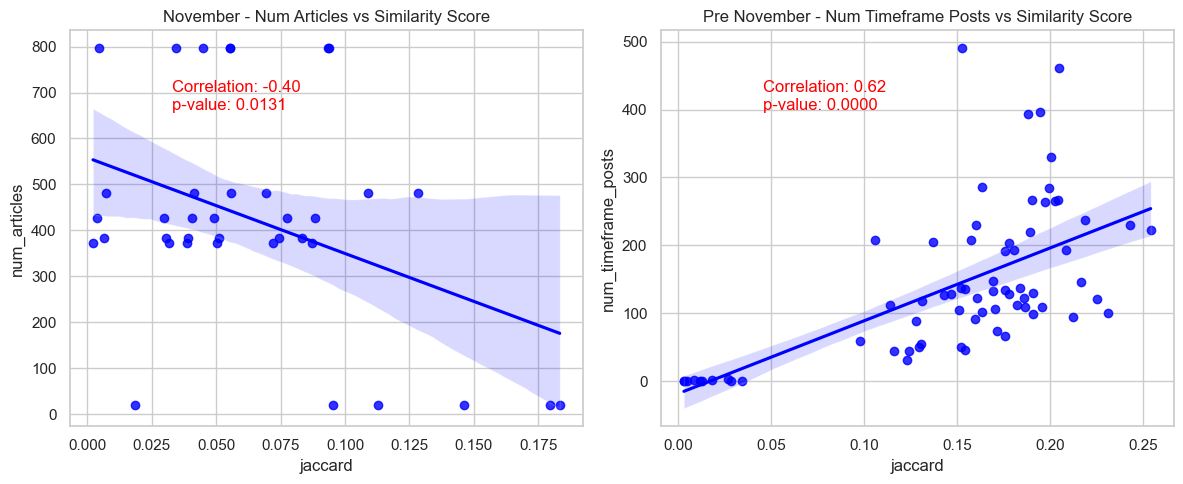

In [18]:
def plot_scatter_with_correlation(data, x_col, y_col, ax):
    sns.regplot(x=x_col, y=y_col, data=data, ax=ax, color='blue')
    correlation, p_value = scipy.stats.pearsonr(data[x_col], data[y_col])
    ax.text(0.2, 0.8, f'Correlation: {correlation:.2f}\np-value: {p_value:.4f}', transform=ax.transAxes, color='red')

# Set up a 2x2 subplot grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Scatter plot with 'jaccard' and 'num_articles' for data_nov
plot_scatter_with_correlation(data_nov, 'jaccard', 'num_articles', axes[0])
axes[0].set_title('November - Num Articles vs Similarity Score')

# Scatter plot with 'jaccard' and 'num_timeframe_posts' for data_pre_nov
plot_scatter_with_correlation(data_pre_nov, 'jaccard', 'num_timeframe_posts', axes[1])
axes[1].set_title('Pre November - Num Timeframe Posts vs Similarity Score')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

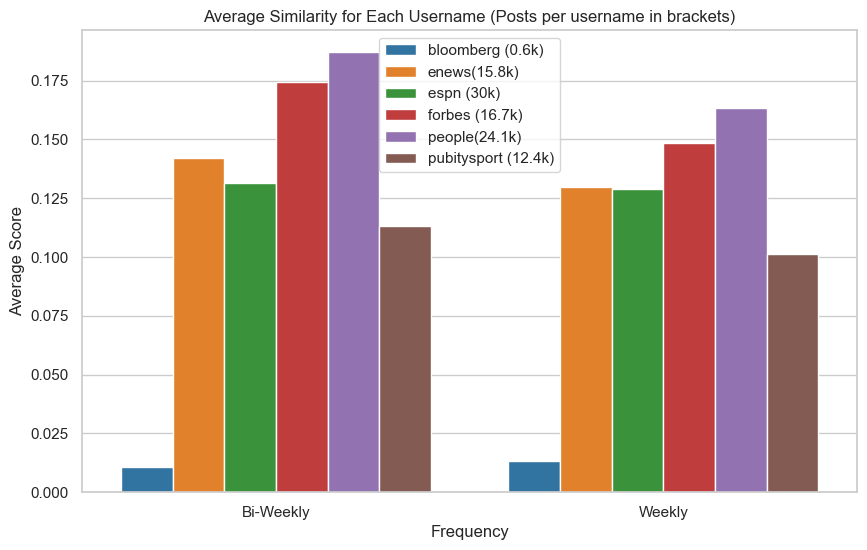

In [39]:
# Calculate the average map score for each username and categorization
average_scores = data_updated_2.groupby(['username', 'Categorisation'])['jaccard'].mean().reset_index()

username_replacements = {
    'forbes': 'forbes (16.7k)',
    'bloomberg': 'bloomberg (0.6k)',
    'espn': 'espn (30k)',
    'pubitysport': 'pubitysport (12.4k)',
    'people': 'people(24.1k)',
    'enews': 'enews(15.8k)'
}

average_scores['username'] = average_scores['username'].replace(username_replacements)

# Create a stacked bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Categorisation', y='jaccard', hue='username', data=average_scores, palette='tab10')

# Add labels and title
plt.xlabel('Frequency')
plt.ylabel('Average Score')
plt.title('Average Similarity for Each Username (Posts per username in brackets)')
plt.legend(loc='upper center')

# Show the plot
plt.show()